In [1]:
from igraph import *
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random

In [2]:
seed = 1234
np.random.seed(seed)
random.seed(seed)

# Generating Random Networks

## 1. Create random networks using the Erdos-Renyi (ER) Model

In [3]:
def degree_fn(g=None):
    if type(g) is Graph:
        freq = collections.Counter(g.degree())
        for key,value in freq.most_common():
            freq[key] = value/g.vcount()
    elif type(g):
        N = len(g)
        freq = collections.Counter(g)
        for key,value in freq.most_common():
            freq[key] = value/N
        
    k,pk = zip(*dict(freq).items())
    return k,pk

In [ ]:
def create_ER(n=1000,p=0.003,verbose=False):
    # sample / create a Erdos-Renyi Graph
    g = Graph.Erdos_Renyi(n,p,directed=False)
    
    k,pk = degree_fn(g)

    if plot:
        plt.figure()
        plt.bar(k,pk,width=0.4)
        plt.xlabel("Node Degree"); plt.ylabel("$p_k$"); plt.title("Degree Distribution p={:.4f} n={:d}".format(p,n))
        plt.show()
        
    if verbose:
        mean_measured = np.mean(g.degree()); mean_theor = n*p;
        var_measured = np.var(g.degree()); var_theor = n*p*(1-p);
        
        print("Mean Measured: {:.3f} ".format(mean_measured))
        print("Mean Theoretical: {:.3f} ".format(mean_theor))
        
        print("Var Measured: {:.3f} ".format(var_measured))
        print("Mean Theoretical: {:.3f}".format(var_theor))
        
        df = pd.DataFrame({"k":k,"pk":pk}).sort_values('k',ignore_index=True).transpose()
        df.columns = df.iloc[0]; df.drop(df.index[0],inplace=True)
        print("Degree Distribution:\n",df)
        
    return g

#### (a). Create undirected random networks with n = 1000 nodes, and the probability p for drawing an edge between two arbitrary vertices 0.003, 0.004, 0.01, 0.05, and 0.1. Plot the degree distributions. What distribution is observed? Explain why. Also, report the mean and variance of the degree distributions and compare them to the theoretical values.
This may be explained by the generation process of the Erdos-Renyi model: 
1. Generate N nodes (specified as a parameter)
2. Generate an edge with probability $p$ (specified as a parameter), which acts as a Bernoulli RV for an edge occuring between any given two nodes), which is done for all $n \choose 2$ possible edges.

This makes sense, as you can imagine that for any given node, there are $N-1$ given nodes to choose from for the node to form an edge with probability $p$, which is a Binomial distribution of $p_k = {n-1 \choose k} p^k (1-p)^{n-1-k}$

Therefore, the degree distribution follows a $\textbf{Binomial distribution}$ which converts to a $\textbf{Poisson distribution}$ for large n and np=constant. 

In [ ]:
N=100; p=0.003;
create_ER(100,0.003,True)
plt.figure()
plt.bar(k,pk,width=0.4)
plt.xlabel("Node Degree"); plt.ylabel("$p_k$"); plt.title("Degree Distribution p={:.4f} n={:d}".format(p,N))
plt.show()

In [ ]:
p_iterate = [0.003,0.004,0.01,0.05,0.1] ; N = 1000
for p in p_iterate:
    create_ER(n=N,p=p,verbose=True,plot=True)

#### (b). For each p and n = 1000, answer the following questions: Are all random realizations of the ER network connected? Numerically estimate the probability that a generated network is connected. For one instance of the networks with that p, find the giant connected component (GCC) if not connected. What is the diameter of the GCC?
It was observed that for $p$ = 0.003,0.004, and 0.01 that there existed graphs that were not connected. However, for $p$ = 0.05 and 0.1 all random realization of the ER network were connected. The diameters of the giant connected component for disconnected graphs are listed in the table below, as well as the numerical estimate of probability of graph being connected.

| p                 | 0.003 | 0.004 | 0.01 | 0.05 | 0.1 |
|-------------------|-------|-------|------|------|-----|
| diameter          | 14    | 11    | 5    | 3    | 3   |
| p[g is connected] | 0     | 0     | 0.962| -1    | -1   |


In [92]:
N_trials = 500
connected_percent = []; diameters = []
for p in p_iterate:
    connect_check = False
    track_connect = []
    for i in tqdm(range(N_trials)):
        g = create_ER(n=N,p=p,verbose=False,plot=False)
        connect_boolean = g.is_connected()
        
        track_connect.append(connect_boolean)
        
        if (not connect_boolean) and (not connect_check):
            connect_check = True
            
            diameters.append(g.clusters().giant().diameter())
            
    del g
    if (not connect_check):
        diameters.append(-1)

    connected_percent.append(mean(track_connect))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 65.12it/s]


In [95]:
df = pd.DataFrame({"Diameter":diameters,"p(G connected)":connected_percent},index=p_iterate)
df.index.name = 'pk'
print(df)

       Diameter  p(G connected)
pk                             
0.003        15           0.000
0.004        11           0.000
0.010         6           0.962
0.050        -1           1.000
0.100        -1           1.000


#### (c). For n = 1000, sweep over values of p from 0 to a pmax that makes the network almost surely connected and create 100 random networks for each p. pmax should be roughly determined by yourself. Then scatter plot the normalized GCC sizes vs p. Plot a line of the average normalized GCC sizes for each p along with the scatter plot.

(i). I define my criterion of "emergence" of giant connected components when the normalized GCC size is approximately 0.95. With this, my emperical estimate of $p$ where the giant connected component starts to emerge is $p$ = 0.011, whereas the theorical point of emergence is $P_{coming} = \frac{1}{n}$ = 0.01.

(ii) The emprical value of p where the giant connected component takes up over 99% of the nodes in almost every experiment is $p$=0.0048.

In [96]:
def get_gcc_normalized(g):
    cluster_obj = Graph.clusters(g)
    network_size = g.vcount()
    giant_size = g.clusters().giant().vcount()
    return giant_size/network_size

In [97]:
pmax=np.log(N)/N
pcoming = 1/N

In [103]:
gcc_normalized = []
p_iterate = np.linspace(1e-5,2*pmax,50)
gcc_normalized_avg = []
for p in tqdm(p_iterate):
    gcc_normalized_temp = []
    for i in range(250):
        g = create_ER(n=N,p=p)
        gcc_normalized_temp.append(get_gcc_normalized(g))
        
    del g
    gcc_normalized.extend(gcc_normalized_temp)
    gcc_normalized_avg.append(np.mean(gcc_normalized_temp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.46s/it]


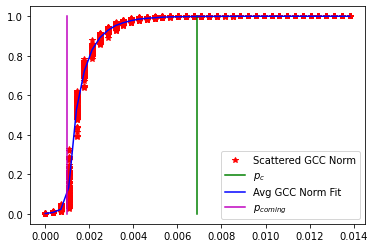

In [100]:
plt.plot(np.repeat(p_iterate,100),gcc_normalized,'r*')
plt.plot([pmax,pmax],[0,1],'g-')
plt.plot(p_iterate,gcc_normalized_avg,'b-')
plt.plot([pcoming,pcoming],[0,1],'m-')
plt.legend(['Scattered GCC Norm','$p_c$','Avg GCC Norm Fit','$p_{coming}$'])
plt.show()

In [108]:
p_max_numerical_estimate = p_iterate[np.nonzero(np.array(gcc_normalized_avg) >= .1)[0][0]]
print("Emperical estimate of p where giant connected component starts to emerge: {:.4f}".format(p_max_numerical_estimate))
print("Theoretical point: {:.4f}".format(pcoming))

Emperical estimate of p where giant connected component starts to emerge: 0.0011
Theoretical point: 0.0010


In [107]:
p_99 = p_iterate[np.nonzero(np.array(gcc_normalized_avg) > .99)[0][0]]
print("Value of p where the giant connected component takes up over 99% of nodes in almost all experiments: {:.4f}".format(p_99))

Value of p where the giant connected component takes up over 99% of nodes in almost all experiments: 0.0048


#### (d). Define the average degree of nodes c = n * p = 0:5. Sweep over the number of nodes, n, ranging from 100 to 10000. Plot the expected size of the GCC of ER networks with n nodes and edge-formation probabilities p = c=n, as a function of n. What trend is observed?

In [104]:
def generate_gcc_sweep(c=0.5,color='r'):
    n_iter = np.arange(100,10100,100)
    p_edge_formation = []
    gcc_avg = []
    for n in tqdm(n_iter):
        p = c/n
        p_edge_formation.append(p)
        gcc_temp = []
        for _ in range(100):
            g = create_ER(n=n,p=p)
            gcc_temp.append(g.clusters().giant().vcount())

        del g
        gcc_avg.append(np.mean(gcc_temp))

    plt.plot(n_iter,gcc_avg,color+'*')
    return n_iter,gcc_avg

(i). The trend observed is close to a logarithmic growth curve, but it does not plateau. The "elbow" may be show to be around n=2000, and there is a linear trend around n=3000 to n=10000.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


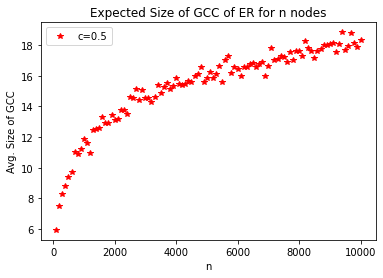

In [109]:
n_iter,gcc_avg = generate_gcc_sweep()
plt.title("Expected Size of GCC of ER for n nodes"); plt.xlabel("n"); plt.ylabel("Avg. Size of GCC")
plt.legend(['c=0.5'])
plt.show()

In [114]:
slope1 = LinearRegression().fit(np.reshape(n_iter,(len(n_iter),-1)),gcc_avg).coef_

(ii) Repeat the same for c = 1.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


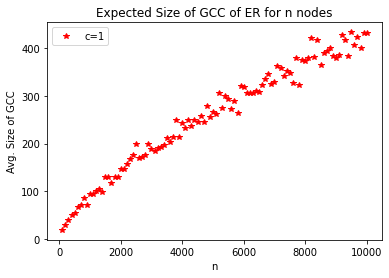

In [116]:
n_iter,gcc_avg = generate_gcc_sweep(c=1)
plt.title("Expected Size of GCC of ER for n nodes"); plt.xlabel("n"); plt.ylabel("Avg. Size of GCC")
plt.legend(['c=1'])
plt.show()

In [117]:
slope2 = LinearRegression().fit(np.reshape(n_iter,(len(n_iter),-1)),gcc_avg).coef_

(iii). In each case for c = 1.1 , 1.2 , 1.3 the relationship between the expected GCC size and n in each case is a first order linear trend, where as c increases, the slope positively increases.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


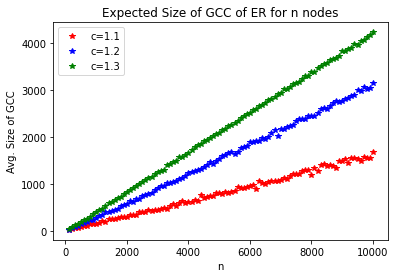

In [118]:
slopes = []
for c,color in zip([1.1,1.2,1.3],['r','b','g']):
    n_iter,gcc_avg = generate_gcc_sweep(c,color)
    slopes.append(LinearRegression().fit(np.reshape(n_iter,(len(n_iter),-1)),gcc_avg).coef_)
    
slope3,slope4,slope5 = slopes
    
plt.title("Expected Size of GCC of ER for n nodes"); plt.xlabel("n"); plt.ylabel("Avg. Size of GCC")
plt.legend(['c=1.1','c=1.2','c=1.3'])
plt.show()

(iv) When c=1 to c=1.3, the average size of GCC over n shows a positive linear correlation, where there is a linear increase in trend of the slope for c > 1.

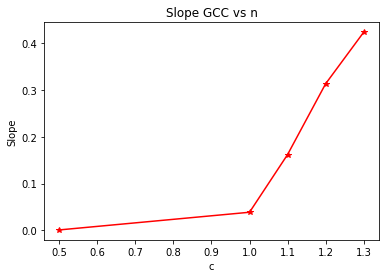

In [127]:
slopes = [np.round(slope[0],6) for slope in [slope1,slope2,slope3,slope4,slope5]]
cs = [0.5,1,1.1,1.2,1.3]
df = pd.DataFrame({"Slope GCC vs n":slopes},index=[0.5,1,1.1,1.2,1.3])
plt.plot(cs,slopes,'r*-'); plt.title("Slope GCC vs n"); plt.xlabel("c"); plt.ylabel("Slope")
plt.show()

## 2. Create random networks using the preferential attachment model

#### (a). Create an undirected network with n = 1000 nodes, with preferential attachment model, where each new node attaches to m = 1 old nodes. Is such a network always connected?

Based on what was discussed and class, and the numerical estimate of probability a preferential attachment model is connected, the network is always connected.

In [128]:
N = 1000; M = 1;
connect_check = []; N_trials = 10000
connect_perc = np.mean([Graph.Barabasi(n=N,m=M,outpref=True,directed=False).is_connected() for _ in range(N_trials)])
print("Graph is connected with prob={:.4f} estimated from {:d} trials".format(connect_perc,N_trials))

Graph is connected with prob=1.0000 estimated from 10000 trials


#### (b). Use fast greedy method to and the community structure. Measure modularity.
From the community structure plot, there is a central hub of communication in the center (green), and then offshoorts of community hubs. The modularity of the network is 0.9340, indicating there is a strong division of the network into communities. The modularity ranges from $[-\frac{1}{2} - 1]$ for undirected, unweighted graphs, where 1 dense connections between the nodes within communities but sparse connections between nodes in different communitities

In [129]:
g_1000 = Graph.Barabasi(n=N,m=M,outpref=True,directed=False)
fastgreedycluster = g_1000.community_fastgreedy().as_clustering()

In [130]:
g = Graph.Barabasi(n=100,m=1)

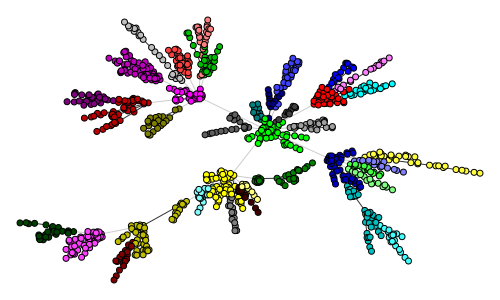

In [131]:
plot(fastgreedycluster,bbox=(0,0,500,300),vertex_size=6,edge_size=10)

In [132]:
print("The network modularity = {:.4f}".format(fastgreedycluster.modularity))

The network modularity = 0.9306


#### (c). Try to generate a larger network with 10000 nodes using the same model. Compute modularity. How is it compared to the smaller network's modularity?
There is still a visible central hub of commuication between communities (the center teal communitiy), but it is less visible than the network generated with 1000 nodes. The modularity has increased almosts 5% relatively , from 0.9340 to 0.9785 .

In [133]:
N = 10000
g_10000 = Graph.Barabasi(n=N,m=M,outpref=True,directed=False)
fastgreedycluster = g_10000.community_fastgreedy().as_clustering()

In [136]:
plot(fastgreedycluster,bbox=(0,0,500,300),vertex_size=6,edge_size=10)

In [137]:
print("The network modularity = {:.4f}".format(fastgreedycluster.modularity))

The network modularity = 0.9782


#### (d) Plot the degree distribution in a log-log scale for both n = 1000; 10000, then estimate the slope of the plot using linear regression

In [138]:
k_1000,pk_1000 = degree_fn(g_1000)
k_10000,pk_10000 = degree_fn(g_10000)

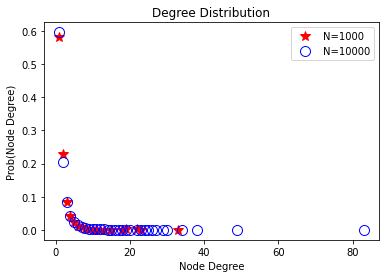

In [139]:
plt.plot(k_1000,pk_1000,'r*',markersize=10)
plt.plot(k_10000,pk_10000,'bo',markersize=10,fillstyle='none')
plt.legend(['N=1000','N=10000']); plt.xlabel("Node Degree"); plt.ylabel("Prob(Node Degree)"); plt.title("Degree Distribution")
plt.show()

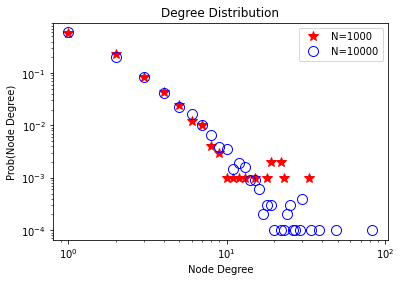

In [140]:
plt.loglog(k_1000,pk_1000,'r*',markersize=10)
plt.loglog(k_10000,pk_10000,'bo',markersize=10,fillstyle='none')
plt.legend(['N=1000','N=10000']); plt.xlabel("Node Degree"); plt.ylabel("Prob(Node Degree)"); plt.title("Degree Distribution")
plt.show()

In [141]:
lm_1000 = LinearRegression().fit(np.log(k_1000)[:,np.newaxis],np.log(pk_1000))
lm_10000 = LinearRegression().fit(np.log(k_10000)[:,np.newaxis],np.log(pk_10000))

In [142]:
print("The slope for Barabasi simulation of n=1000: {:.4f}".format(lm_1000.coef_.item()))
print("The slope for Barabasi simulation of n=10000: {:.4f}".format(lm_10000.coef_.item()))

The slope for Barabasi simulation of n=1000: -2.1471
The slope for Barabasi simulation of n=10000: -2.5595


In [143]:
del fastgreedycluster

#### (e) In the two networks generated in 2(d), perform the following: Randomly pick a node i, and then randomly pick a neighbor j of that node. Plot the degree distribution of nodes j that are picked with this process, in the log-log scale. Is the distribution linear in the log-log scale? If so, what is the slope? How does this differ from the node degree distribution?
The degree distribution of the nodes $j$ that are picked with this process is not linear in the log-log scale, but rather has curve that is flat from node degree 1 to 3, but then drops off almost linear from node degree 4-9 and then plateaus to constant around node degree 10 onwards. Previously in (2d) the n=1000 and n=10000 degree distribution graphs plateaud at different points, $10e^{-4}$ and $10e^{-5}$ respectively, but now for the neighborhood sample approach both n=1000 and n=10000 plateau around $10e^{-2}$. The neighbor sample approach gives higher degree nodes (fatter tails of the degree probability distribution) compared to the previous approach, which may be explained because most sampled nodes will only have 1 edge which leads to a high degree vertex node, since the preferential attachment network grows by adding a node with one edge to another node proportional to its degree. The rich get richer!

In [144]:
def sample(g=None):
    degrees = []
    sampled_nodes = np.random.choice(g_1000.vs,10000)
    for node in sampled_nodes:
        neighbors = node.neighbors()
        neighbor_sample = np.random.choice(neighbors,1)[0]
        degrees.append(neighbor_sample.degree())
    return degrees

In [145]:
k_1000_neighbor,pk_1000_neighbor = degree_fn(sample(g_1000))
k_10000_neighbor,pk_10000_neighbor = degree_fn(sample(g_10000))

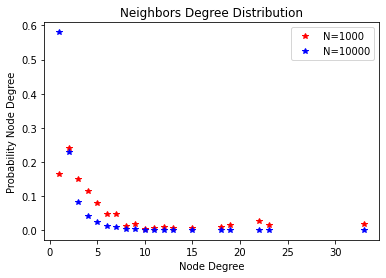

In [150]:
plt.plot(k_1000_neighbor,pk_1000_neighbor,'r*')
plt.plot(k_1000,pk_1000,'b*')
plt.xlabel("Node Degree"); plt.ylabel("Prob(Node Degree)"); plt.title('Neighbors Degree Distribution')
plt.legend(['N=1000','N=10000'])
plt.show()

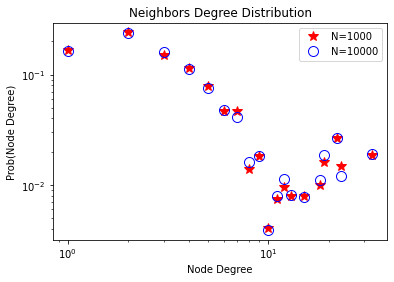

In [152]:
plt.loglog(k_1000_neighbor,pk_1000_neighbor,'r*',markersize=10)
plt.loglog(k_10000_neighbor,pk_10000_neighbor,'bo',markersize=10,fillstyle='none')
plt.legend(['N=1000','N=10000']); plt.xlabel("Node Degree"); plt.ylabel("Prob(Node Degree)"); plt.title("Neighbors Degree Distribution")
plt.show()

In [153]:
del k_1000_neighbor,k_10000_neighbor,pk_1000_neighbor,pk_10000_neighbor

#### (f). Estimate the expected degree of a node that is added at time step i for 1 < i < 1000. Show the relationship between the age of nodes and their expected degree through an appropriate plot.

In [154]:
def avg_degree_over_time(M=1,color='r'):
    g = Graph.Barabasi(n=1,m=M,outpref=True,directed=False)
    deg_avg = [g.degree_distribution().mean]
    for t in range(1,1001,1):
        g = Graph.Barabasi(n=1+t*M,m=M,outpref=True,directed=False,start_from=g)
        deg_avg.append(g.degree_distribution().mean)

    plt.plot(np.arange(1001),deg_avg,color+'-')
    plt.title("Expected Degree of node added at time step $t$")
    plt.xlabel("time step (t)"); plt.ylabel("Expected Degree of Node at t")

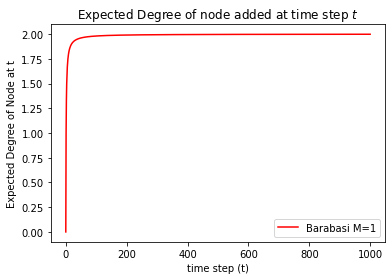

In [155]:
avg_degree_over_time()
plt.legend(['Barabasi M=1'])

#### (g). Repeat the previous parts for m = 2; and m = 5. Compare the results of each part for different values of m.
There is a trend where the steady state average degree is $2M$ which is consistent with what we derived in class, as the average degree of a network is $\frac{2|E|}{|V|} = \frac{2tM}{|t|} = 2M$

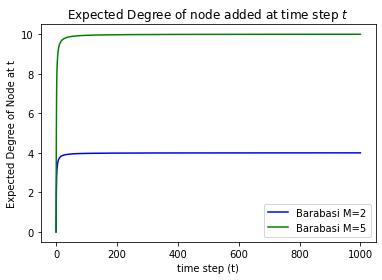

In [165]:
avg_degree_over_time(M=2,color='b')
avg_degree_over_time(M=5,color='g')
plt.legend(['Barabasi M=2','Barabasi M=5'])
plt.show()

#### (h). Again, generate a preferential attachment network with n = 1000, m = 1. Take its degree sequence and create a new network with the same degree sequence, through stub-matching procedure. Plot both networks, mark communities on their plots, and measure their modularity. Compare the two procedures for creating random power-law networks.
They have approximately the same modularity of 0.93, but the two procedures for creating random power-law networks is different. Preferential attachment will add in one node at a time sequentially with one edge, where the connection node is proportional to the degree distibution whereas the sequence degree will sample N nodes first, then pick a degree for a particular node from the degree distribution, and then afterwards match stubs between nodes with equal probability. Another major difference is the preferential attachment degree sequence is stochastic, whereas the degree sequence itself is deterministic, because rather than sample nodes from the degree distribution and then connect stubs, this model is given nodes and number of stubs directly from the generated preferential attachment graph.

In [157]:
g = Graph.Barabasi(n=1000,m=1,outpref=True,directed=False)
g_dd_fixed = Graph.Degree_Sequence(g.degree(),method='vl')

In [158]:
g_cluster = g.community_fastgreedy().as_clustering()
g_dd_cluster = g_dd_fixed.community_fastgreedy().as_clustering()

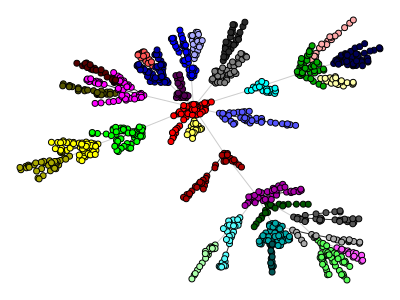

In [159]:
plot(g_cluster,bbox=(0,0,400,300),vertex_size=6)

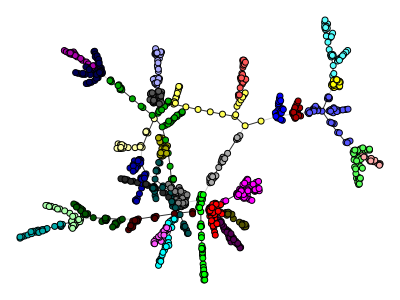

In [160]:
plot(g_dd_cluster,bbox=(0,0,400,300),vertex_size=6)

In [161]:
print("The network modularity Degree Sequence= {:.4f}".format(g_dd_cluster.modularity))
print("The network modularity Barbasi (Preferential)= {:.4f}".format(g_cluster.modularity))

The network modularity Degree Sequence= 0.9340
The network modularity Barbasi (Preferential)= 0.9328


In [162]:
del g, g_dd_fixed,g_cluster,g_dd_cluster

## 3. Create a modified preferential attachment model that penalizes the age of a node

#### (a). Each time a new vertex is added, it creates m links to old vertices and the probabilitythat an old vertex is cited depends on its degree (preferential attachment) and age.
The power law fit function gave the power law exponent of 5.6118 .

In [198]:
def sample_pa_age(N=1000,M=1,alpha=1,beta=-1,a=1,b=0,c=1,d=1):
    g = Graph()
    g.add_vertices(N)
    ages = np.zeros(N)
    node_ids = np.arange(N)
    avg_degree = []
    
    for t in tqdm(np.arange(1,N)):
        k = np.array(g.degree()[:t])#[node.degree() for node in g.vs[:t]])
        ages[:t] = ages[:t] + 1
        p_unnorm = (c*(k**alpha) + a)*(d*(ages[:t]**beta) + b)
        p = p_unnorm / np.sum(p_unnorm)
            
        if M > t:
            edges = [(t,node) for node in np.random.choice(node_ids[:t],size=(t,),replace=False,p=p)]
        else:
            edges = [(t,node) for node in np.random.choice(node_ids[:t],size=(M,),replace=False,p=p)]
                             
        g.add_edges(edges)
        
        avg_degree.append(np.mean(g.degree()[:t]))
            
    return g,avg_degree

In [199]:
g,avg_degree = sample_pa_age(N=1000,M=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 2350.81it/s]


In [200]:
power_law_fit = statistics.power_law_fit(g.degree())

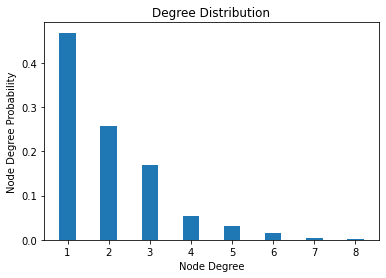

In [201]:
k,pk = degree_fn(g)

plt.bar(k,pk,width=0.4)
plt.xlabel("Node Degree"); plt.ylabel("Node Degree Probability"); plt.title("Degree Distribution")
plt.show()

In [203]:
print("The power law exponent of the the Age bias Preferential Model: {:.4f}".format(power_law_fit.alpha))

The power law exponent of the the Age bias Preferential Model: 4.1896


#### (b) Use fast greedy method to nd the community structure. What is the modularity?

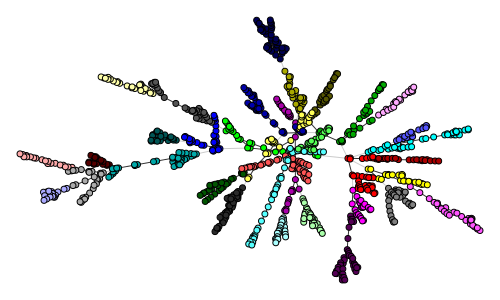

In [202]:
g_greedy = g.community_fastgreedy().as_clustering()
plot(g_greedy,bbox=(0,0,500,300),vertex_size=6,edge_size=10)

In [204]:
print("The modularity of the the Age bias Preferential Model: {:.4f}".format(g_greedy.modularity))

The modularity of the the Age bias Preferential Model: 0.9356


# 2. Random Walk On Networks

## 1. Random Walk on Erdos-Renyi networks

In [212]:
def random_walk_statistics(g,N_trials=1000,steps=100):
    distances = []
    degrees = []
    N_trials = N_trials; steps = steps;
    for _ in tqdm(range(N_trials)):
        start_node = np.random.choice(g.vcount())
        #end_node, path = random_walk(g,steps,start_node)
        path = g.random_walk(start_node,steps)
        
        degrees.append(g.vs[path[-1]].degree())

        path_set = set(path)
        dist_dict = dict(zip(path_set,g.vs[start_node].shortest_paths(path_set)[0]))
        distances.append([dist_dict[node] for node in path])
        
    dist_array = np.array(distances)
    mu_t = dist_array.mean(0)
    var_t = dist_array.var(0)
    t = np.arange(steps)
    
    return t,mu_t,var_t,degrees

In [228]:
def random_walk_plot(t,mu_t,var_t):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(t,mu_t,'*')
    plt.plot([g.diameter(),g.diameter()],[0,np.max(mu_t)],'g-')
    plt.xlabel("time step",fontsize=15); plt.legend(['<s(t)>','k=diameter(g)']); plt.ylabel('Mean Distance'); plt.title('<s(t)>')

    plt.subplot(1,2,2)
    plt.plot(t,var_t,'*')
    plt.plot([g.diameter(),g.diameter()],[0,np.max(var_t)],'g-')
    plt.xlabel("time step",fontsize=15); plt.legend(['$<(s(t) - <s(t)>)^2>$','k=diameter(g)']);
    plt.title("$<(s(t) - <s(t)>)^2>$")
    plt.show()

In [229]:
def degree_distribution_plot(degrees):
    plt.figure()
    k,pk = degree_fn(degrees)
    k2,pk2 = degree_fn(g)
    plt.plot(k,pk,'r*')
    plt.plot(k2,pk2,'b*')
    plt.legend(["End Node","Graph"]); plt.ylabel("Node Degree Probability"); plt.xlabel("Node Degree"); 
    plt.title("Degree Distribution")

#### (a). Create an undirected random network with 1000 nodes, and the probability p for drawing an edge between any pair of nodes equal to 0.01.

In [230]:
g = create_ER(1000,0.01)

#### (b). Let a random walker start from a randomly selected node (no teleportation). Weuse t to denote the number of steps that the walker has taken. Measure the average distance (defined as the shortest path length) hs(t)i of the walker from his starting point at step t. Also, measure the variance of this distance. Plot $\mu_s(t)$ v.s. t and $\sigma_s^2(t)$ v.s. t. Here, the average $<\cdot>$ is over random choices of the starting nodes.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1495.33it/s]


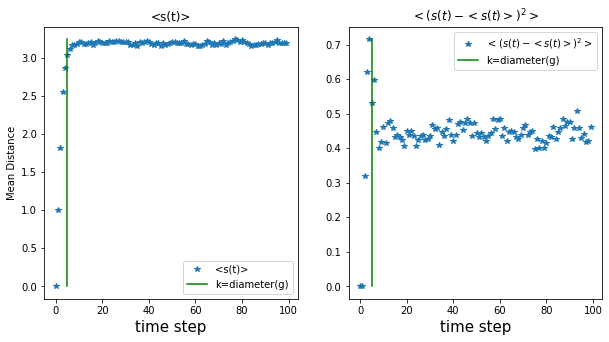

In [231]:
t,mu_t,var_t,degrees = random_walk_statistics(g,N_trials=1000,steps=100)
random_walk_plot(t,mu_t,var_t)

#### (c). Measure the degree distribution of the nodes reached at the end of the random walk. How does it compare to the degree distribution of graph?
The node deree distribution of the graph versus the degree distribution of the nodes reached at the end of the random walk is very similar, but the node degree at the end is slightly shifted to the right.

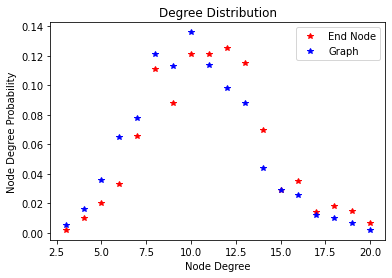

In [234]:
degree_distribution_plot(degrees)

#### (d). Repeat 1(b) for undirected random networks with 10000 nodes. Compare the results and explain qualitatively. Does the diameter of the network play a role?
The mean of the node degree and standard deviation of the node degree over time reach a steady state at the network diameter length from observing the plots over time steps of the random walk.

In [238]:
g = create_ER(10000,0.01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.86it/s]


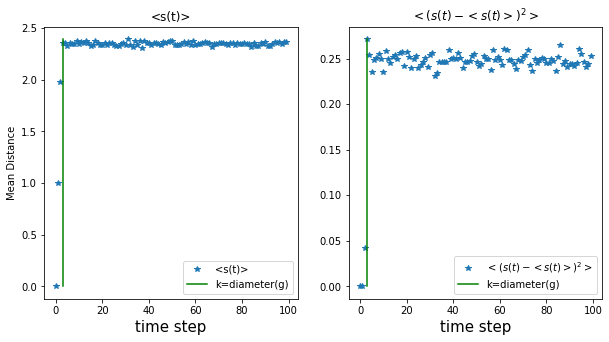

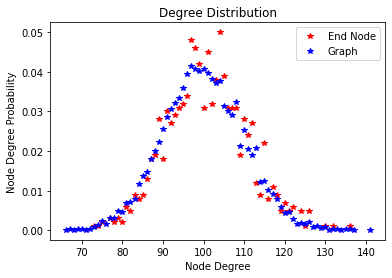

In [239]:
t,mu_t,var_t,degrees = random_walk_statistics(g,N_trials=1000,steps=100)
random_walk_plot(t,mu_t,var_t)
degree_distribution_plot(degrees)

## Random Walk on Networks with fat-tailed degree distribution

#### (a). Generate an undirected preferential attachment network with 1000 nodes, where each new node attaches to m = 1 old nodes

In [241]:
N = 1000; M = 1;
g = Graph.Barabasi(n=N,m=M,outpref=True)

#### (b) Let a random walker start from a randomly selected node. Measure and plot <s(t)> v.s. t and $\sigma^2(t)$ v.s. t. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1953.70it/s]


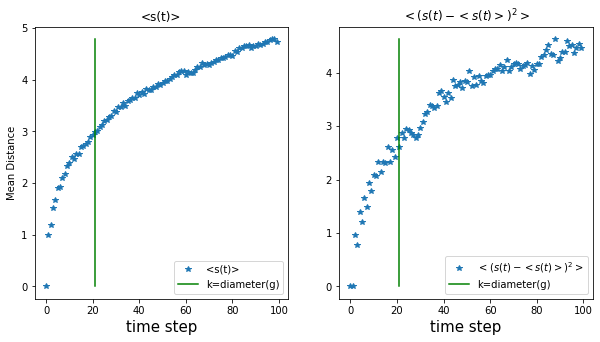

In [242]:
t,mu_t,var_t,degrees  = random_walk_statistics(g,N_trials=1000,steps=100,plot_=True)
random_walk_plot(t,mu_t,var_t)

#### (c) Measure the degree distribution of the nodes reached at the end of the random walk on this network. How does it compare with the degree distribution of the graph?
The nodes reached at the end of the random walk on this network has a slightly fatter-tailed degree distribution then the degree distribution of the graph. This may be explained because the random walk will most likely end of at nodes with larger degrees.

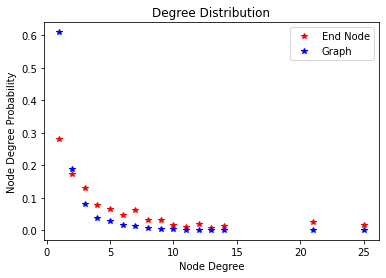

In [243]:
degree_distribution_plot(degrees)

#### (d) Repeat 2(b) for preferential attachment networks with 100 and 10000 nodes, and m = 1. Compare the results and explain qualitatively. Does the diameter of the network play a role?
Unlike the Erdos-Renyi model, the diameter does not appear to play a role in the average node degree or variance of node degree as a function of time.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13668.37it/s]


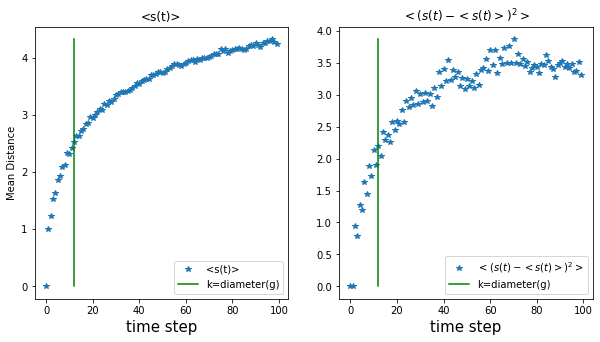

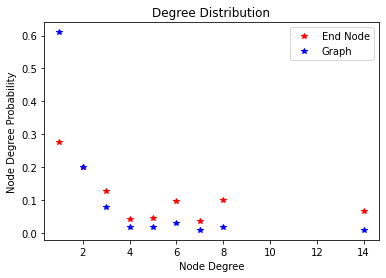

In [244]:
N = 100; M = 1;
g = Graph.Barabasi(n=N,m=M,outpref=True)
t,mu_t,var_t,degrees = random_walk_statistics(g,N_trials=1000,steps=100,plot_=True)
random_walk_plot(t,mu_t,var_t)
degree_distribution_plot(degrees)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.25it/s]


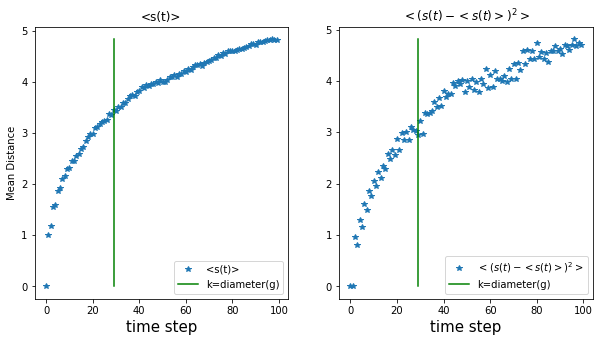

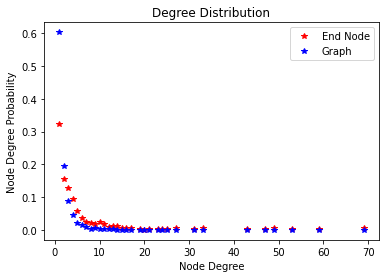

In [245]:
N = 10000; 
g = Graph.Barabasi(n=N,m=M,outpref=True)
t,mu_t,var_t,degrees = random_walk_statistics(g,N_trials=1000,steps=100,plot_=True)
random_walk_plot(t,mu_t,var_t)
degree_distribution_plot(degrees)

## (3.) PageRank

#### (a). Create such a network using m = 4. Measure the probability that the walker visits each node. Is this probability related to the degree of the nodes?
There is a positive correlation of the pagerank probability with the in-degree of a node, and a slight negative correlation of the pagerank probability with the out-degree of a node, as observered by the scatterplots (it seems that the out degree of a node does not affect the pagerank as much as the in-degree). This makes sense as the more incoming links from other nodes (especially nodes with low out degree), the more votes the node gets and therefore the higher corresponding probability of the node being visited

In [259]:
N = 1000; M = 4;
g = Graph.Barabasi(n=N,m=M,outpref=False,directed=True)
g_add = Graph.Barabasi(n=N,m=M,outpref=False,directed=True)
g_add_permute = g_add.permute_vertices(np.random.choice(g_add.vcount(),size=g_add.vcount(),replace=False).tolist())
g.add_edges(g_add_permute.get_edgelist())

In [260]:
g_giant = g.clusters().giant()
p_pagerank_99 = g_giant.pagerank(damping=0.99)

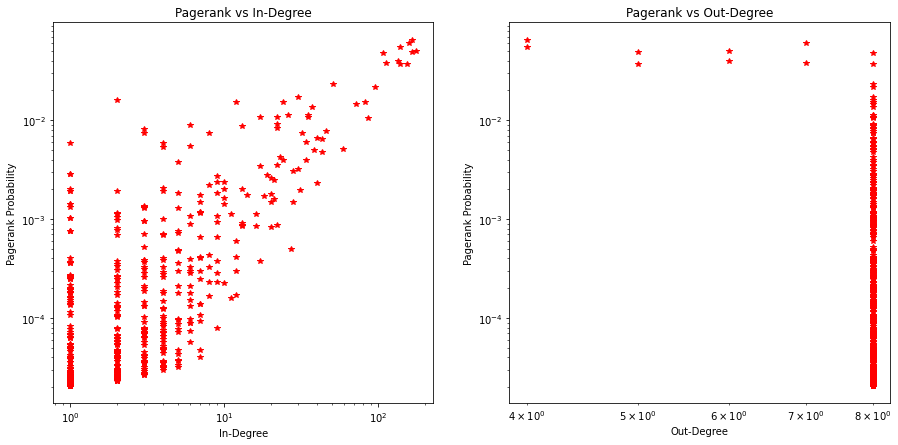

In [261]:
plt.subplots(2,2,figsize=(15,7))
plt.subplot(1,2,1)
plt.loglog(g_giant.indegree(),p_pagerank_99,'r*')
plt.title("Pagerank vs In-Degree"); plt.xlabel("In-Degree"); plt.ylabel("Pagerank Probability")
plt.subplot(1,2,2)
plt.loglog(g_giant.outdegree(),p_pagerank_99,'r*')
plt.title("Pagerank vs Out-Degree"); plt.xlabel("Out-Degree"); plt.ylabel("Pagerank Probability")
plt.show()

#### (b). In all previous questions, we didn't have any teleportation. Now, we use a teleportation probability of $\alpha$ = 0.15. By performing random walks on the network created in 3(a), measure the probability that the walker visits each node. Is this probability related to the degree of the node? 
There is a comparable positive correlation of the pagerank probability with the in-degree of a node compared to 3(a), and a comparable negative correlation of the pagerank probability with the out-degree of a node, as observered by the scatterplots.

In [266]:
p_pagerank_85 = np.array(g.pagerank(damping=0.85))

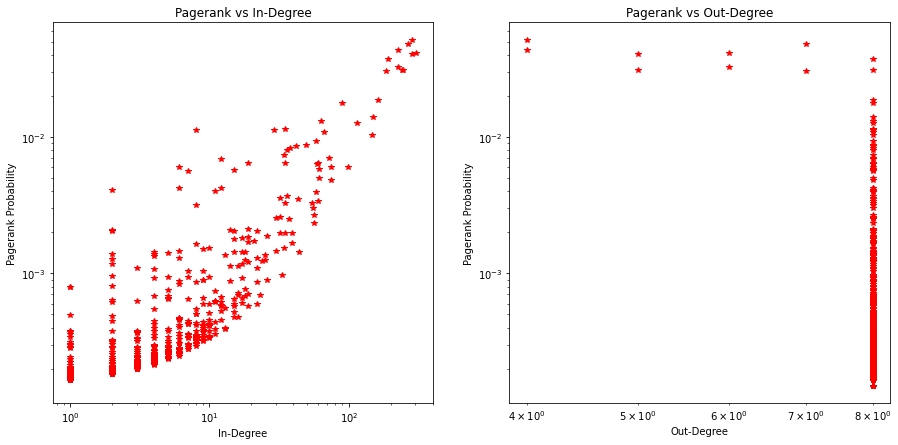

In [267]:
plt.subplots(2,2,figsize=(15,7))
plt.subplot(1,2,1)
plt.loglog(g.indegree(),p_pagerank_85,'r*')
plt.title("Pagerank vs In-Degree"); plt.xlabel("In-Degree"); plt.ylabel("Pagerank Probability")
plt.subplot(1,2,2)
plt.loglog(g.outdegree(),p_pagerank_85,'r*')
plt.title("Pagerank vs Out-Degree"); plt.xlabel("Out-Degree"); plt.ylabel("Pagerank Probability")
plt.show()

## 4. Personalized PageRank

#### (a) Suppose you have your own notion of importance. Your interest in a node is proportional to the node's PageRank, because you totally rely upon Google to decide which website to visit (assume that these nodes represent websites). Again, use random walk on network generated in question 3 to simulate this personalized PageRank. Here the teleportation probability to each node is proportional to its PageRank (as opposed to the regular PageRank, where at teleportation, the chance of visiting all nodes are the same and equal to 1/N). Again, let the teleportation probability be equal to $\alpha$ = 0:15. Compare the results with 3(a).
Compared with 3(a), there is now no correlation between the in-degree of a node and the probability of the node being visited. There also is no longer a slight negative correlation between the out-degree of a node and the probability of the node being visited.

In [268]:
bias = g.pagerank(damping=.85)
p_pagerank_bias = g.personalized_pagerank(reset=bias)

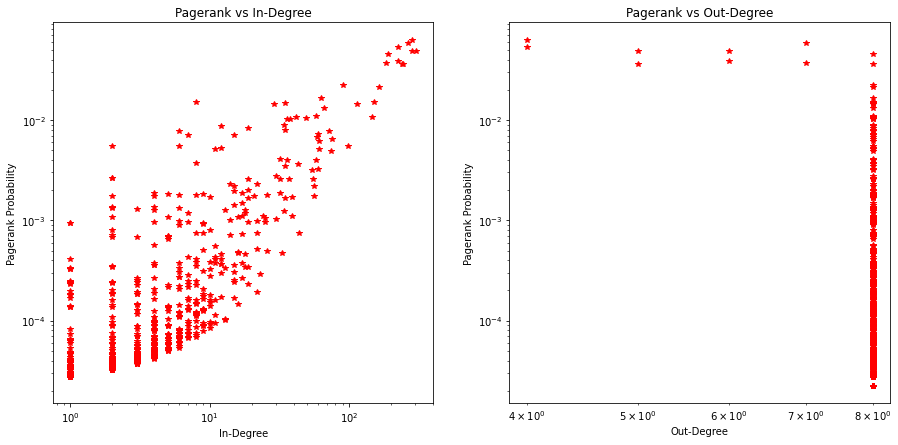

In [269]:
plt.subplots(2,2,figsize=(15,7))
plt.subplot(1,2,1)
plt.loglog(g.indegree(),p_pagerank_bias,'r*')
plt.title("Pagerank vs In-Degree"); plt.xlabel("In-Degree"); plt.ylabel("Pagerank Probability")
plt.subplot(1,2,2)
plt.loglog(g.outdegree(),p_pagerank_bias,'r*')
plt.title("Pagerank vs Out-Degree"); plt.xlabel("Out-Degree"); plt.ylabel("Pagerank Probability")
plt.show()

#### (b). Find two nodes in the network with median PageRanks. Repeat part 4(a) if teleportations land only on those two nodes (with probabilities 1/2, 1/2). How are the PageRank values affected?
When the teloportation lands only on the two nodes with probabilities 1/2 and 1/2, then the two nodes become the highest visited nodes in the network, as the probability of visit increases by 2 orders of magnitude.

In [270]:
median = np.median(p_pagerank_85)
print("The graph pagerank median is: {:.6f}".format(median))
two_nodes = np.argsort(np.abs(np.array(p_pagerank_85) - median))[:2].tolist()
print("The two nodes closest to the median are: ",two_nodes)
p_personalized_twonodes = np.array(g.personalized_pagerank(reset_vertices=two_nodes))
print("The two nodest closest to the median probability of visit are with vanilla pagerank are: ",p_pagerank_85[two_nodes])
print("The two nodest closest to the median probability of visit are with personalized pagerank are: ",p_personalized_twonodes[two_nodes])

The graph pagerank median is: 0.000187
The two nodes closest to the median are:  [101, 325]
The two nodest closest to the median probability of visit are with vanilla pagerank are:  [0.00018731 0.00018731]
The two nodest closest to the median probability of visit are with personalized pagerank are:  [0.075 0.075]


#### (c). More or less, 4(b) is what happens in the real world, in that a user browsing the web only teleports to a set of trusted web pages. However, this is against the assumption of normal PageRank, where we assume that people's interest in all nodes are the same. Can you take into account the effect of this self-reinforcement and adjust the PageRank equation?
To take into account that the assumption of normal pagerank assuming people's interest in all nodes are the same, I have readjusted the probability of visit given teleportation to reflect non-uniform probability on the same two nodes from 4 (a). Now, the probability of visit given teleportation is 0.1 and 0.9 for nodes 784 and 492 respectively. 

Previously, the personalized pagerank produced probability of visit of 0.075 for both nodes 784 and 492, which makes sense as the bias was equal before, but now because the random surfer is more biased towards node 492, there is a huge disparity for the probability of visit for nodes 784 and 492 (0.015 and 0.135 respectively).

In [271]:
p_self_interest = np.zeros(g.vcount())
p_self_interest[two_nodes] = [0.1,0.9]
p_personalized_twonodes = np.array(g.personalized_pagerank(reset=p_self_interest.tolist()))
print("The two nodest closest to the median probability of visit are with vanilla pagerank are: ",p_pagerank_85[two_nodes])
print("The two nodest closest to the median probability of visit are with personalized pagerank are: ",p_personalized_twonodes[two_nodes])

The two nodest closest to the median probability of visit are with vanilla pagerank are:  [0.00018731 0.00018731]
The two nodest closest to the median probability of visit are with personalized pagerank are:  [0.015 0.135]
